In [56]:
# run this ONCE
# !pip install scikit-fuzzy

In [57]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
# Load your dataset (assuming it's in a CSV file)
data = pd.read_csv('daily_weather.csv')

# Define input and output variables
trainIn = data.iloc[:, 1:-2]
trainOut = data.iloc[:, -2]

In [59]:
# Normalize the input variables (0 to 1)
trainIn = (trainIn - trainIn.min()) / (trainIn.max() - trainIn.min())

# Initialize ANFIS parameters
minTrainRMSE = 1000
trainSF = 0
trainAR = 0
trainRR = 0
fisResult = []

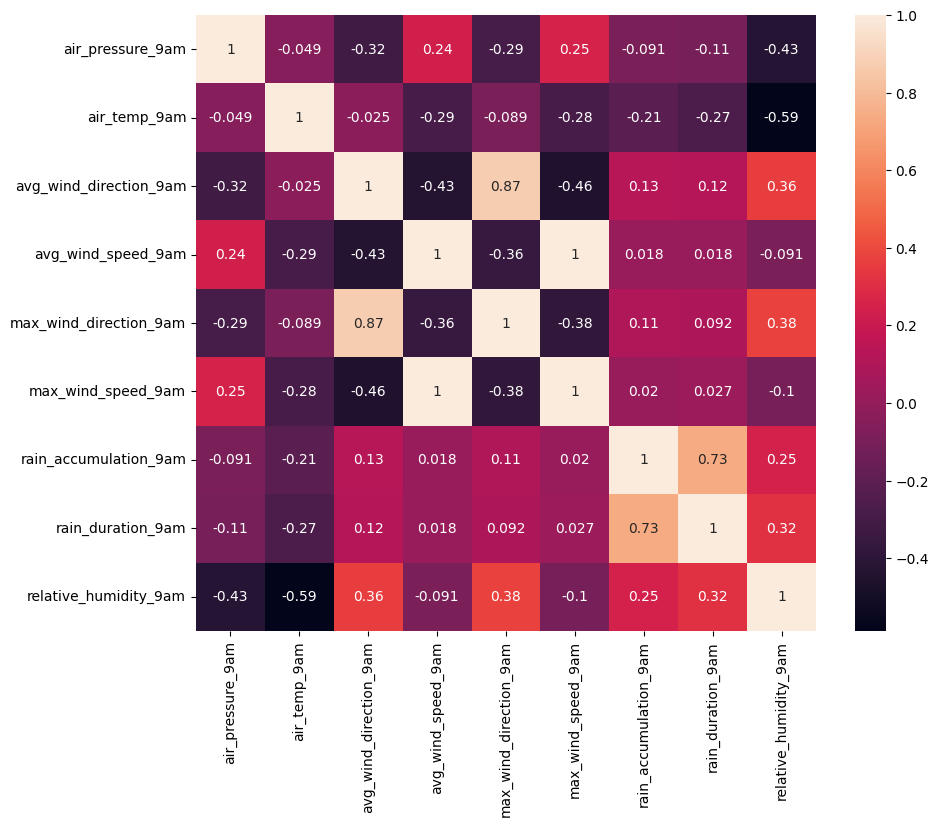

In [60]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.iloc[:, 1:-1].corr(), annot=True)
plt.show()

In [61]:
trainIn

,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_accumulation_9am,rain_duration_9am
0,0.472105,0.612511,0.779506,0.060665,0.940699,0.058548,0.000000,0.000000
1,0.438710,0.557516,0.263602,0.076528,0.393828,0.081931,0.000000,0.000000
2,0.705579,0.384304,0.108265,0.716243,0.122838,0.729899,0.000000,0.001130
3,0.586627,0.537164,0.559110,0.159391,0.643499,0.139747,0.000000,0.000000
4,0.617440,0.121344,0.799939,0.050881,0.379809,0.058548,0.370525,0.832015
...,...,...,...,...,...,...,...,...
1090,0.511486,0.423979,0.541019,0.138943,0.629721,0.140515,0.000000,0.000000
1091,0.502579,0.206198,0.689539,0.048924,0.700671,0.041374,0.000000,0.000000
1092,0.403657,0.552563,0.530040,0.103718,0.606777,0.094457,0.000000,0.000000
1093,0.216128,0.348393,0.479414,0.136986,0.565478,0.124902,0.000000,0.000000


array([[<Axes: title={'center': 'air_pressure_9am'}>,
        <Axes: title={'center': 'air_temp_9am'}>,
        <Axes: title={'center': 'avg_wind_direction_9am'}>],
       [<Axes: title={'center': 'avg_wind_speed_9am'}>,
        <Axes: title={'center': 'max_wind_direction_9am'}>,
        <Axes: title={'center': 'max_wind_speed_9am'}>],
       [<Axes: title={'center': 'rain_accumulation_9am'}>,
        <Axes: title={'center': 'rain_duration_9am'}>, <Axes: >]],
      dtype=object)

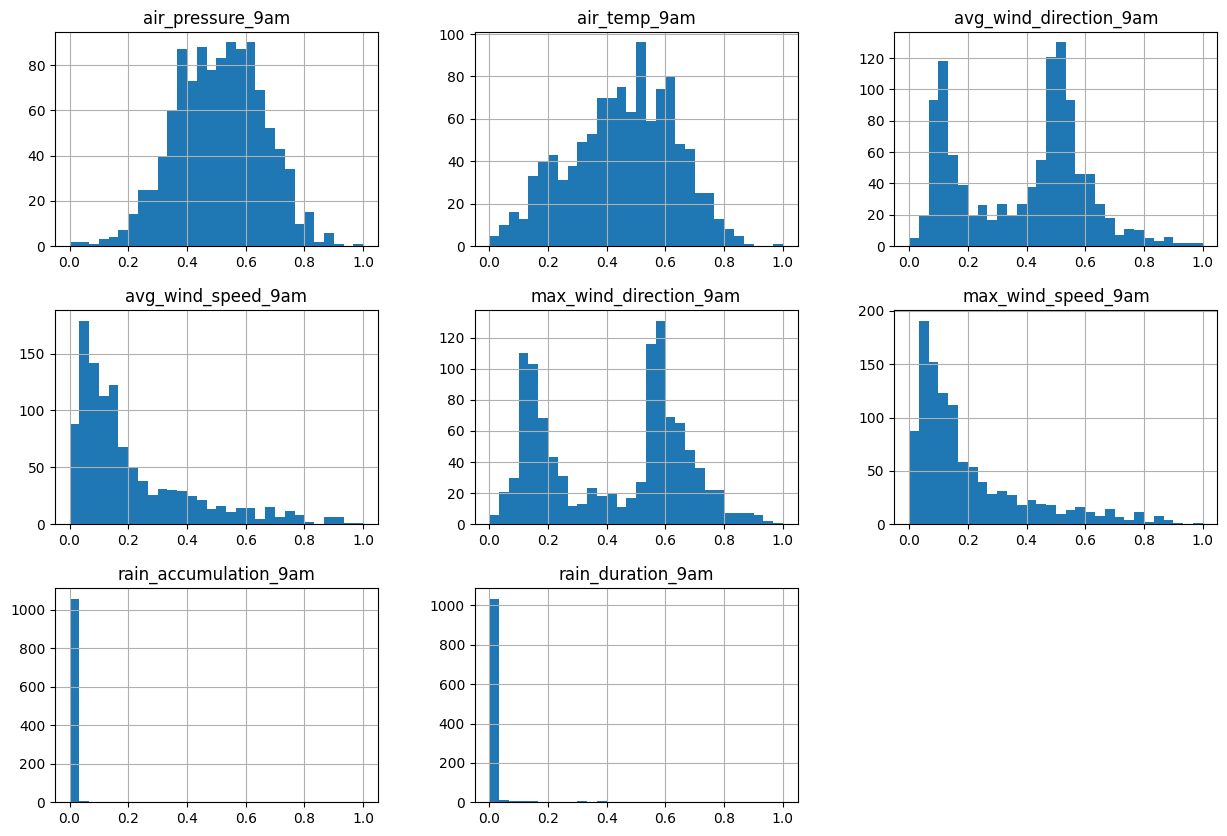

In [62]:
trainIn.hist(bins=30, figsize=(15, 10))

<Axes: >

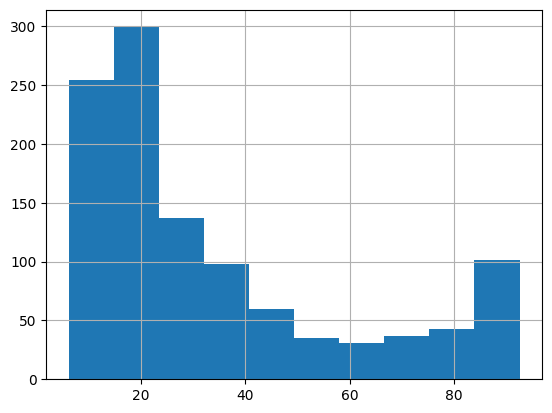

In [63]:
trainOut.hist()

In [64]:
trainOut.describe()

count    1095.000000
mean       34.241402
std        25.472067
min         6.090000
25%        15.092243
50%        23.179259
75%        45.400000
max        92.620000
Name: relative_humidity_9am, dtype: float64

In [65]:
data.iloc[:, 1:-1].describe()

,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_accumulation_9am,rain_duration_9am,relative_humidity_9am
count,1092.000000,1090.000000,1091.000000,1092.000000,1092.000000,1091.000000,1089.000000,1092.000000,1095.000000
mean,918.882551,64.933001,142.235511,5.508284,148.953518,7.019514,0.203079,294.108052,34.241402
std,3.184161,11.175514,69.137859,4.552813,67.238013,5.598209,1.593952,1598.078779,25.472067
min,907.990000,36.752000,15.500000,0.693451,28.900000,1.185578,0.000000,0.000000,6.090000
25%,916.550000,57.281000,65.972506,2.248768,76.553003,3.067477,0.000000,0.000000,15.092243
50%,918.921045,65.715479,166.000000,3.871333,177.300000,4.943637,0.000000,0.000000,23.179259
75%,921.160073,73.450974,191.000000,7.337163,201.233153,8.947760,0.000000,0.000000,45.400000
max,929.320000,98.906000,343.400000,23.554978,312.200000,29.840780,24.020000,17704.000000,92.620000


In [66]:
# look at some random rows to infer rules
data.iloc[np.random.randint(0, len(data), 10), 1:-1].head(10)

,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_accumulation_9am,rain_duration_9am,relative_humidity_9am
113,922.880000,53.744000,186.900000,2.818544,223.200000,3.668582,0.00,0.000000,28.680000
57,920.030000,66.992000,172.500000,2.460634,168.100000,3.310671,0.00,0.000000,29.890000
460,916.300000,63.302000,184.800000,6.129216,201.200000,7.695074,0.00,0.000000,13.830000
1063,917.300185,65.790001,NaN,1.879553,222.498226,2.692862,0.00,0.000000,14.972668
525,917.400000,61.916000,251.800000,1.767183,267.400000,2.326418,0.00,0.000000,20.560000
490,917.400000,77.234000,230.700000,1.856660,201.800000,2.639589,3.13,2980.000000,14.310000
42,921.500000,49.550000,90.700000,1.744813,112.300000,2.684328,1.53,5420.000000,34.350000
401,921.510534,60.510215,45.953118,20.724381,58.418304,25.527550,0.01,54.015253,11.458017
877,916.029175,87.136183,211.488359,1.576819,110.292240,2.589370,0.00,0.000000,12.622753
234,915.610000,69.314000,46.700000,10.916267,64.500000,14.204569,0.00,10.000000,8.300000


In [74]:
for InfluenceRange in [0.5]:
    for sf in np.arange(0.25, 2.25, 0.25):
        for ar in np.arange(0.2, 1.1, 0.1):
            for rr in np.arange(0.1, ar, 0.1):
                print(f'\nProcessing  IR = {InfluenceRange}, SF = {sf}, AR = {ar}, RR = {rr}\n')

                # Create fuzzy input variables
                air_pressure = ctrl.Antecedent(np.sort(trainIn['air_pressure_9am'].to_numpy()), 'air_pressure')
                air_temp = ctrl.Antecedent(np.sort(trainIn['air_temp_9am'].to_numpy()), 'air_temp')
                avg_wind_direction = ctrl.Antecedent(np.sort(trainIn['avg_wind_direction_9am'].to_numpy()), 'avg_wind_direction')
                avg_wind_speed = ctrl.Antecedent(np.sort(trainIn['avg_wind_speed_9am'].to_numpy()), 'avg_wind_speed')
                max_wind_direction = ctrl.Antecedent(np.sort(trainIn['max_wind_direction_9am'].to_numpy()), 'max_wind_direction')
                max_wind_speed = ctrl.Antecedent(np.sort(trainIn['max_wind_speed_9am'].to_numpy()), 'max_wind_speed')
                rain_accumulation =  ctrl.Antecedent(np.sort(trainIn['rain_accumulation_9am'].to_numpy()), 'rain_accumulation')
                rain_duration =  ctrl.Antecedent(np.sort(trainIn['rain_duration_9am'].to_numpy()), 'rain_duration')

                # Create the output variable
                humidity = ctrl.Consequent(np.sort(trainOut.to_numpy()), 'humidity')

                # Define fuzzy membership functions and rules (you'll need to customize this part)
                # Example:
                # air pressure
                air_pressure['low'] = fuzz.trimf(air_pressure.universe, [trainIn['air_pressure_9am'].min(), trainIn['air_pressure_9am'].quantile(0.25), trainIn['air_pressure_9am'].quantile(0.5)])
                air_pressure['medium'] = fuzz.trimf(air_pressure.universe, [trainIn['air_pressure_9am'].quantile(0.25), trainIn['air_pressure_9am'].quantile(0.5), trainIn['air_pressure_9am'].quantile(0.75)])
                air_pressure['high'] = fuzz.trimf(air_pressure.universe, [trainIn['air_pressure_9am'].quantile(0.5), trainIn['air_pressure_9am'].quantile(0.75), trainIn['air_pressure_9am'].max()])
                # air temp
                air_temp['low'] = fuzz.trimf(air_pressure.universe, [trainIn['air_temp_9am'].min(), trainIn['air_temp_9am'].quantile(0.25), trainIn['air_temp_9am'].quantile(0.5)])
                air_temp['medium'] = fuzz.trimf(air_pressure.universe, [trainIn['air_temp_9am'].quantile(0.25), trainIn['air_temp_9am'].quantile(0.5), trainIn['air_temp_9am'].quantile(0.75)])
                air_temp['high'] = fuzz.trimf(air_pressure.universe, [trainIn['air_temp_9am'].quantile(0.5), trainIn['air_temp_9am'].quantile(0.75), trainIn['air_temp_9am'].max()])
                # avg wind direction
                avg_wind_direction['low'] = fuzz.trimf(air_pressure.universe, [trainIn['avg_wind_direction_9am'].min(), trainIn['avg_wind_direction_9am'].quantile(0.25), trainIn['avg_wind_direction_9am'].quantile(0.5)])
                avg_wind_direction['medium'] = fuzz.trimf(air_pressure.universe, [trainIn['avg_wind_direction_9am'].quantile(0.25), trainIn['avg_wind_direction_9am'].quantile(0.5), trainIn['avg_wind_direction_9am'].quantile(0.75)])
                avg_wind_direction['high'] = fuzz.trimf(air_pressure.universe, [trainIn['avg_wind_direction_9am'].quantile(0.5), trainIn['avg_wind_direction_9am'].quantile(0.75), trainIn['avg_wind_direction_9am'].max()])
                # avg wind speed
                avg_wind_speed['low'] = fuzz.trimf(air_pressure.universe, [trainIn['avg_wind_speed_9am'].min(), trainIn['avg_wind_speed_9am'].quantile(0.25), trainIn['avg_wind_speed_9am'].quantile(0.5)])
                avg_wind_speed['medium'] = fuzz.trimf(air_pressure.universe, [trainIn['avg_wind_speed_9am'].quantile(0.25), trainIn['avg_wind_speed_9am'].quantile(0.5), trainIn['avg_wind_speed_9am'].quantile(0.75)])
                avg_wind_speed['high'] = fuzz.trimf(air_pressure.universe, [trainIn['avg_wind_speed_9am'].quantile(0.5), trainIn['avg_wind_speed_9am'].quantile(0.75), trainIn['avg_wind_speed_9am'].max()])
                # max wind direction
                max_wind_direction['low'] = fuzz.trimf(air_pressure.universe, [trainIn['max_wind_direction_9am'].min(), trainIn['max_wind_direction_9am'].quantile(0.25), trainIn['max_wind_direction_9am'].quantile(0.5)])
                max_wind_direction['medium'] = fuzz.trimf(air_pressure.universe, [trainIn['max_wind_direction_9am'].quantile(0.25), trainIn['max_wind_direction_9am'].quantile(0.5), trainIn['max_wind_direction_9am'].quantile(0.75)])
                max_wind_direction['high'] = fuzz.trimf(air_pressure.universe, [trainIn['max_wind_direction_9am'].quantile(0.5), trainIn['max_wind_direction_9am'].quantile(0.75), trainIn['max_wind_direction_9am'].max()])
                # max wind speed
                max_wind_speed['low'] = fuzz.trimf(air_pressure.universe, [trainIn['max_wind_speed_9am'].min(), trainIn['max_wind_speed_9am'].quantile(0.25), trainIn['max_wind_speed_9am'].quantile(0.5)])
                max_wind_speed['medium'] = fuzz.trimf(air_pressure.universe, [trainIn['max_wind_speed_9am'].quantile(0.25), trainIn['max_wind_speed_9am'].quantile(0.5), trainIn['max_wind_speed_9am'].quantile(0.75)])
                max_wind_speed['high'] = fuzz.trimf(air_pressure.universe, [trainIn['max_wind_speed_9am'].quantile(0.5), trainIn['max_wind_speed_9am'].quantile(0.75), trainIn['max_wind_speed_9am'].max()])
                # rain accumulation
                rain_accumulation['low'] = fuzz.trimf(air_pressure.universe, [trainIn['rain_accumulation_9am'].min(), trainIn['rain_accumulation_9am'].quantile(0.25), trainIn['rain_accumulation_9am'].quantile(0.5)])
                rain_accumulation['medium'] = fuzz.trimf(air_pressure.universe, [trainIn['rain_accumulation_9am'].quantile(0.25), trainIn['rain_accumulation_9am'].quantile(0.5), trainIn['rain_accumulation_9am'].quantile(0.75)])
                rain_accumulation['high'] = fuzz.trimf(air_pressure.universe, [trainIn['rain_accumulation_9am'].quantile(0.5), trainIn['rain_accumulation_9am'].quantile(0.75), trainIn['rain_accumulation_9am'].max()])
                # rain duration
                rain_duration['low'] = fuzz.trimf(air_pressure.universe, [trainIn['rain_duration_9am'].min(), trainIn['rain_duration_9am'].quantile(0.25), trainIn['rain_duration_9am'].quantile(0.5)])
                rain_duration['medium'] = fuzz.trimf(air_pressure.universe, [trainIn['rain_duration_9am'].quantile(0.25), trainIn['rain_duration_9am'].quantile(0.5), trainIn['rain_duration_9am'].quantile(0.75)])
                rain_duration['high'] = fuzz.trimf(air_pressure.universe, [trainIn['rain_duration_9am'].quantile(0.5), trainIn['rain_duration_9am'].quantile(0.75), trainIn['rain_duration_9am'].max()])

                # try with automf
                # air_pressure.automf(3)
                # air_temp.automf(3)
                # avg_wind_direction.automf(3)
                # avg_wind_speed.automf(3)
                # max_wind_direction.automf(3)
                # max_wind_speed.automf(3)
                # rain_accumulation.automf(3)
                # rain_duration.automf(3)

                # Define membership functions for the output variable
                humidity['low'] = fuzz.trimf(humidity.universe, [trainOut.min(), trainOut.quantile(0.25), trainOut.quantile(0.5)])
                humidity['medium'] = fuzz.trimf(humidity.universe, [trainOut.quantile(0.25), trainOut.quantile(0.5), trainOut.quantile(0.75)])
                humidity['high'] = fuzz.trimf(humidity.universe, [trainOut.quantile(0.5), trainOut.quantile(0.75), trainOut.max()])
                # Define other membership functions for the output variable

                # Create fuzzy rules
                rule1 = ctrl.Rule(air_pressure['high'] & air_temp['high'] & avg_wind_direction['low'] & avg_wind_speed['high'] & max_wind_direction['medium'], humidity['low'])
                rule2 = ctrl.Rule(avg_wind_direction['high'] & max_wind_direction['high'] & rain_accumulation['high'], humidity['high'])
                rule3 = ctrl.Rule(avg_wind_direction['low'] & max_wind_direction['low'] & rain_duration['low'], humidity['high'])
                rule4 = ctrl.Rule(air_pressure['low'] & air_temp['low'], humidity['low'])
                rule5 = ctrl.Rule(avg_wind_speed['medium'] & max_wind_speed['medium'] & rain_accumulation['low'] & rain_duration['low'], humidity['low'])

                # Create fuzzy control system
                system = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])  # Add all your rules here

                # Simulate the fuzzy system
                sim = ctrl.ControlSystemSimulation(system)

                # Set input values
                sim.input['air_pressure'] = trainIn['air_pressure_9am'].values
                sim.input['air_temp'] = trainIn['air_temp_9am'].values
                sim.input['avg_wind_direction'] = trainIn['avg_wind_direction_9am'].values
                sim.input['avg_wind_speed'] = trainIn['avg_wind_speed_9am'].values
                sim.input['max_wind_direction'] = trainIn['max_wind_direction_9am'].values
                sim.input['max_wind_speed'] = trainIn['max_wind_speed_9am'].values
                sim.input['rain_accumulation'] = trainIn['rain_accumulation_9am'].values
                sim.input['rain_duration'] = trainIn['rain_duration_9am'].values

                # Compute the output
                sim.compute()
                trainFuzOut = sim.output['humidity']

                # Calculate RMSE
                trainRMSE = np.sqrt(mean_squared_error(trainFuzOut, trainOut))

                if trainRMSE < minTrainRMSE:
                    minTrainRMSE = trainRMSE
                    trainSF = sf
                    trainAR = ar
                    trainRR = rr

                fisResult.append([InfluenceRange, sf, ar, rr, trainRMSE])


Processing  IR = 0.5, SF = 0.25, AR = 0.2, RR = 0.1



TypeError: ignored

In [ ]:
# Save the results or do further analysis as needed
fisResult = np.array(fisResult)
np.savetxt('fis_results.csv', fisResult, delimiter=',', header='InfluenceRange,SF,AR,RR,RMSE', comments='')

In [ ]:
# Plot the results
plt.plot(data.index[:100], trainOut[:100], '*r', label='Actual Output')
plt.plot(data.index[:100], trainFuzOut[:100], 'pb', label='ANFIS Output')
plt.legend(loc='upper right')
plt.xlabel('Index')
plt.ylabel('Output')
plt.savefig('output_plot.png')